In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.cm as cm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import string
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pyarabic.araby as araby
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
# read the data
df_test_neg=pd.read_csv('test_Arabic_tweets_negative_20190413.tsv', sep='\t',names=['Sentiment Label', 'Arabic tweet'])
df_test_pos=pd.read_csv('test_Arabic_tweets_positive_20190413.tsv', sep='\t',names=['Sentiment Label', 'Arabic tweet'])
df_train_neg=pd.read_csv('train_Arabic_tweets_negative_20190413.tsv', sep='\t',names=['Sentiment Label', 'Arabic tweet'])
df_train_pos=pd.read_csv('train_Arabic_tweets_positive_20190413.tsv', sep='\t',names=['Sentiment Label', 'Arabic tweet'])

In [182]:
df_test_neg.head()

,Sentiment Label,Arabic tweet
0,neg,حتى الايتونز خربتوه مو صاحين انتو؟؟ 😭
1,neg,واحد تبع النظام السوري يقول أن المخابرات السور...
2,neg,الى متى التعامل السئ للخادمات وعدم احترامهم وك...
3,neg,رايح جاي ي طحلبي 🐸 #الهلال_الاهلي
4,neg,تتمغط ومعها سداع 😫


# Data Preparation

In [130]:
print(len(df_test_neg))
print(len(df_test_pos))
print(len(df_train_neg))
print(len(df_train_pos))

5768
5752
22514
22761


In [131]:
#Checking null values count
print(df_test_neg.isnull().sum())
print(df_test_pos.isnull().sum())
print(df_train_neg.isnull().sum())
print(df_train_pos.isnull().sum())

Sentiment Label    0
Arabic tweet       0
dtype: int64
Sentiment Label    0
Arabic tweet       0
dtype: int64
Sentiment Label    0
Arabic tweet       0
dtype: int64
Sentiment Label    0
Arabic tweet       0
dtype: int64


In [132]:
df_test_neg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5768 entries, 0 to 5767
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Sentiment Label  5768 non-null   object
 1   Arabic tweet     5768 non-null   object
dtypes: object(2)
memory usage: 90.3+ KB


In [133]:
df_test_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5752 entries, 0 to 5751
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Sentiment Label  5752 non-null   object
 1   Arabic tweet     5752 non-null   object
dtypes: object(2)
memory usage: 90.0+ KB


In [134]:
df_train_neg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22514 entries, 0 to 22513
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Sentiment Label  22514 non-null  object
 1   Arabic tweet     22514 non-null  object
dtypes: object(2)
memory usage: 351.9+ KB


In [135]:
df_train_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22761 entries, 0 to 22760
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Sentiment Label  22761 non-null  object
 1   Arabic tweet     22761 non-null  object
dtypes: object(2)
memory usage: 355.8+ KB


In [136]:
# cleaning tweet text
for letter in '#.][!XR':
    df_test_neg['Arabic tweet'] = df_test_neg['Arabic tweet'].astype(str).str.replace(letter,'')
    df_test_pos['Arabic tweet'] = df_test_pos['Arabic tweet'].astype(str).str.replace(letter,'')
    df_train_neg['Arabic tweet'] = df_train_neg['Arabic tweet'].astype(str).str.replace(letter,'')
    df_train_pos['Arabic tweet'] = df_train_pos['Arabic tweet'].astype(str).str.replace(letter,'')

In [137]:
df_test_pos.head()

,Sentiment Label,Arabic tweet
0,pos,الهلال_الاهلي فوز هلالي مهم الحمد لله 💙 زوران ...
1,pos,صباحك خيرات ومسرات 🌸
2,pos,تأمل قال الله ﷻ :- _*​﴿بواد غير ذي زرع ﴾*_ 💫💫 ...
3,pos,😂😂 يا جدعان الرجاله اللي فوق ال دول خطر ع تويت...
4,pos,رساله صباحيه : 💛 اللهم اسألك التوفيق في جميع ا...


In [138]:
#removing punctuations
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [ ]:
#normalize_arabic_text
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

In [140]:
# remove_repeating_char
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [ ]:
# strip_diacritics
df_test_neg['Arabic tweet'] = df_test_neg['Arabic tweet'].apply(araby.strip_diacritics)
df_test_pos['Arabic tweet'] = df_test_pos['Arabic tweet'].apply(araby.strip_diacritics)
df_train_neg['Arabic tweet'] = df_train_neg['Arabic tweet'].apply(araby.strip_diacritics)
df_train_pos['Arabic tweet'] = df_train_pos['Arabic tweet'].apply(araby.strip_diacritics)

In [142]:
df_test_neg.head()

,Sentiment Label,Arabic tweet
0,neg,حتى الايتونز خربتوه مو صاحين انتو؟؟ 😭
1,neg,واحد تبع النظام السوري يقول أن المخابرات السور...
2,neg,الى متى التعامل السئ للخادمات وعدم احترامهم وك...
3,neg,رايح جاي ي طحلبي 🐸 الهلال_الاهلي
4,neg,تتمغط ومعها سداع 😫


In [ ]:
#Remove and replace mentions, hashtags, links and special characters
def processPost(tweet): 

    #Replace @username with empty string
    tweet = re.sub('@[^\s]+', ' ', tweet)
    
    #Convert www.* or https?://* to " "
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',tweet)
    
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)

    # remove punctuations
    tweet= remove_punctuations(tweet)
    
    # remove repeated letters
    tweet=remove_repeating_char(tweet)
    
    return tweet

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Mua\AppData\Local\Temp\ipykernel_22752\2521359334.py:5: SyntaxWarning: invalid escape sequence '\s'
  tweet = re.sub('@[^\s]+', ' ', tweet)
C:\Users\Mua\AppData\Local\Temp\ipykernel_22752\2521359334.py:8: SyntaxWarning: invalid escape sequence '\.'
  tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',tweet)


In [144]:
# apply used to call the method processpost
df_test_neg["Arabic tweet"] = df_test_neg['Arabic tweet'].apply(lambda x: processPost(x)) 
df_test_pos["Arabic tweet"] = df_test_pos['Arabic tweet'].apply(lambda x: processPost(x)) 
df_train_neg["Arabic tweet"] = df_train_neg['Arabic tweet'].apply(lambda x: processPost(x)) 
df_train_pos["Arabic tweet"] = df_train_pos['Arabic tweet'].apply(lambda x: processPost(x))

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
# Apply tokenization to the 'text' column
df_test_neg['tokens'] = df_test_neg["Arabic tweet"].apply(tokenizer.tokenize)
df_test_pos['tokens'] = df_test_pos["Arabic tweet"].apply(tokenizer.tokenize)
df_train_neg['tokens'] = df_train_neg["Arabic tweet"].apply(tokenizer.tokenize)
df_train_pos['tokens'] = df_train_pos["Arabic tweet"].apply(tokenizer.tokenize)


In [146]:
df_test_neg.head()

,Sentiment Label,Arabic tweet,tokens
0,neg,حتى الايتونز خربتوه مو صاحين انتو 😭,"[حتى, الايتونز, خربتوه, مو, صاحين, انتو]"
1,neg,واحد تبع النظام السوري يقول أن المخابرات السور...,"[واحد, تبع, النظام, السوري, يقول, أن, المخابرا..."
2,neg,الى متى التعامل السئ لخادمات وعدم احترامهم وكأ...,"[الى, متى, التعامل, السئ, لخادمات, وعدم, احترا..."
3,neg,رايح جاي ي طحلبي 🐸 الهلالالاهلي,"[رايح, جاي, ي, طحلبي, الهلالالاهلي]"
4,neg,تمغط ومعها سداع 😫,"[تمغط, ومعها, سداع]"


In [ ]:
stopwords_list = stopwords.words('arabic')


In [149]:
stopwords_list


['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'

In [150]:
print(len(stopwords_list))


754


# EDA

In [151]:
df_mearge_pos=pd.concat([df_train_pos,df_test_pos])
df_mearge_neg=pd.concat([df_train_neg,df_test_neg])

In [152]:
df_mearge_pos

,Sentiment Label,Arabic tweet,tokens
0,pos,نحن الذين يتحول كل ما نود أن نقوله إلى دعاء له...,"[نحن, الذين, يتحول, كل, ما, نود, أن, نقوله, إل..."
1,pos,وفي النهاية لن يبقى معك آحدإلا من رأى الجمال ف...,"[وفي, النهاية, لن, يبقى, معك, آحدإلا, من, رأى,..."
2,pos,من الخير نفسه 💛,"[من, الخير, نفسه]"
3,pos,زلزلالملعبنصرنابيلعب كن عالي الهمه ولا ترضى بغ...,"[زلزلالملعبنصرنابيلعب, كن, عالي, الهمه, ولا, ت..."
4,pos,الشيء الوحيد الذي وصلوا فيه لعالمية هو المسيار...,"[الشيء, الوحيد, الذي, وصلوا, فيه, لعالمية, هو,..."
...,...,...,...
5747,pos,ربي اغفر لي و لوالدي و لأحبتي و لمؤمنين و المؤ...,"[ربي, اغفر, لي, و, لوالدي, و, لأحبتي, و, لمؤمن..."
5748,pos,ربي يسعدنا وياكم 💛,"[ربي, يسعدنا, وياكم]"
5749,pos,يتحدثون عن اخلاق حسين ونجوم فرقهم نهاياتهم الر...,"[يتحدثون, عن, اخلاق, حسين, ونجوم, فرقهم, نهايا..."
5750,pos,صباحكم احتفالية لم تكتمل وصاحب الاحتفاليه ماكم...,"[صباحكم, احتفالية, لم, تكتمل, وصاحب, الاحتفالي..."


In [153]:
df_mearge_neg

,Sentiment Label,Arabic tweet,tokens
0,neg,اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم...,"[اعترف, ان, بتس, كانو, شوي, شوي, يجيبو, راسي, ..."
1,neg,توقعت اذا جات داريا بشوفهم كاملين بس لي لحين ا...,"[توقعت, اذا, جات, داريا, بشوفهم, كاملين, بس, ل..."
2,neg,الاهليالهلال اكتب توقعك لنتيجة لقاء الهلال وال...,"[الاهليالهلال, اكتب, توقعك, لنتيجة, لقاء, الهل..."
3,neg,نعمة المضادات الحيوية تضع قطرة💧مضاد بنسلين على...,"[نعمة, المضادات, الحيوية, تضع, قطرة, مضاد, بنس..."
4,neg,الدودو جايه تكمل علي 💔,"[الدودو, جايه, تكمل, علي]"
...,...,...,...
5763,neg,النوم وانت مكسور ده احساس غبي الي هو مش قادر ت...,"[النوم, وانت, مكسور, ده, احساس, غبي, الي, هو, ..."
5764,neg,استشهادالامامكاظمالغيظ السلام على المعذب في قع...,"[استشهادالامامكاظمالغيظ, السلام, على, المعذب, ..."
5765,neg,انا كنت اكل الصحن بكبره 😐,"[انا, كنت, اكل, الصحن, بكبره]"
5766,neg,قولوا لي ايش تشوفوا مع ملاحظة التلطف لأنه المو...,"[قولوا, لي, ايش, تشوفوا, مع, ملاحظة, التلطف, ل..."


In [154]:
# see the most word frequancy in postive with number of frequancy
df_mearge_pos['tokens'].explode().value_counts()

tokens
من           6534
اله          5354
في           5164
على          4144
و            3618
             ... 
والخيالات       1
والتأملات       1
سكروز           1
بطايه           1
راسبين          1
Name: count, Length: 48503, dtype: int64

In [155]:
# see the most word frequancy in negtive with number of frequancy
df_mearge_neg['tokens'].explode().value_counts()

tokens
من             6468
في             4313
و              3363
اله            3101
ما             2601
               ... 
باعصابي           1
يجمد              1
كيفهالاغنية       1
شلحلو             1
ثاقل              1
Name: count, Length: 46936, dtype: int64

findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font f

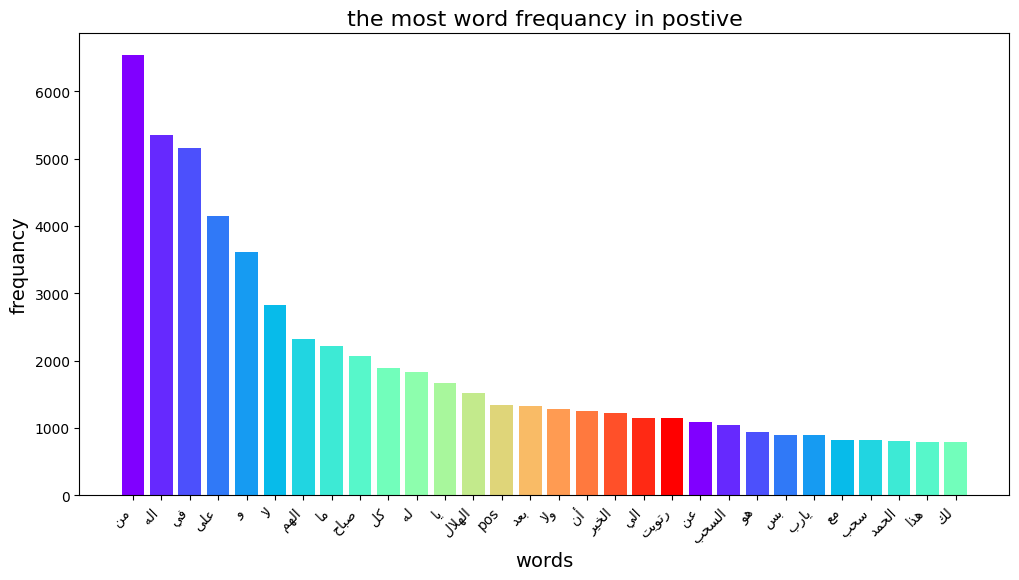

In [ ]:



# Assume your DataFrame is named df_mearge_pos and contains a column "tokens"
# that holds token lists for each row.
# Change the font to one that is installed and supports Arabic
# 1. Get the top 30 most frequent tokens
token_counts = df_mearge_pos['tokens'].explode().value_counts().head(30)

# 2. Reshape each token for proper Arabic rendering:
reshaped_tokens = [get_display(arabic_reshaper.reshape(token)) for token in token_counts.index]
# 3. Set up Matplotlib to use an Arabic-supporting font.
# Change 'Amiri' to another Arabic font if necessary (e.g., 'Noto Naskh Arabic', 'Cairo', etc.)
plt.rcParams['font.family'] = 'Amiri'
plt.rcParams['axes.unicode_minus'] = False

colors = cm.rainbow(np.linspace(0, 1, 20))
# 4. Plot the bar chart with custom color and Arabic labels:
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(reshaped_tokens, token_counts.values, color=colors)

# Reshape and reverse the Arabic labels for title and axes:
title_ar = get_display(arabic_reshaper.reshape("the most word frequancy in postive"))
xlabel_ar = get_display(arabic_reshaper.reshape("words"))
ylabel_ar = get_display(arabic_reshaper.reshape("frequancy"))

ax.set_title(title_ar, fontsize=16)
ax.set_xlabel(xlabel_ar, fontsize=14)
ax.set_ylabel(ylabel_ar, fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.show()


findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font f

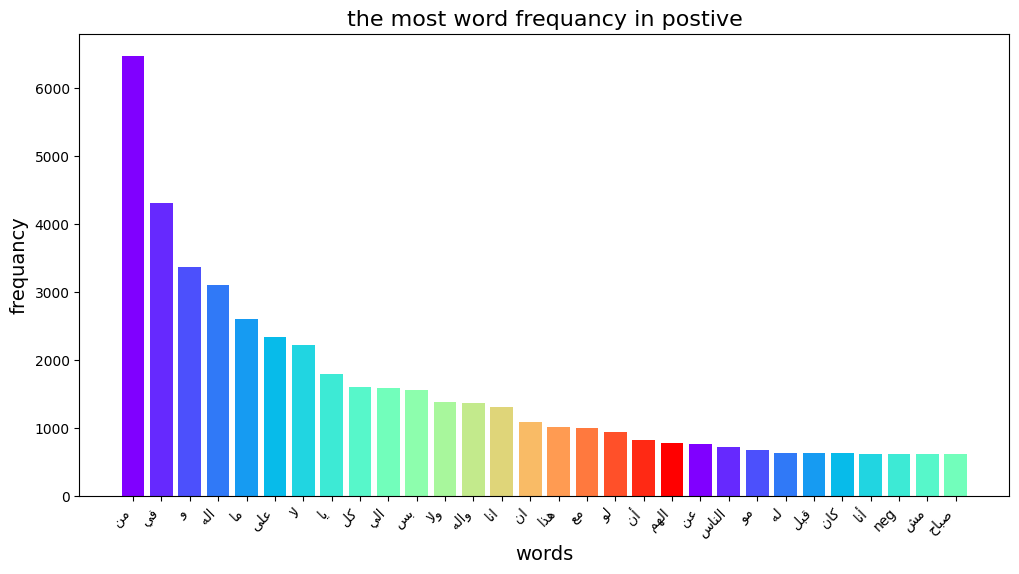

In [ ]:
# Assume your DataFrame is named df_mearge_pos and contains a column "tokens"
# that holds token lists for each row.
# Change the font to one that is installed and supports Arabic
# 1. Get the top 30 most frequent tokens
token_counts = df_mearge_neg['tokens'].explode().value_counts().head(30)

# 2. Reshape each token for proper Arabic rendering:
reshaped_tokens = [get_display(arabic_reshaper.reshape(token)) for token in token_counts.index]
# 3. Set up Matplotlib to use an Arabic-supporting font.
# Change 'Amiri' to another Arabic font if necessary (e.g., 'Noto Naskh Arabic', 'Cairo', etc.)
plt.rcParams['font.family'] = 'Amiri'
plt.rcParams['axes.unicode_minus'] = False

colors = cm.rainbow(np.linspace(0, 1, 20))
# 4. Plot the bar chart with custom color and Arabic labels:
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(reshaped_tokens, token_counts.values, color=colors)

# Reshape and reverse the Arabic labels for title and axes:
title_ar = get_display(arabic_reshaper.reshape("the most word frequancy in postive"))
xlabel_ar = get_display(arabic_reshaper.reshape("words"))
ylabel_ar = get_display(arabic_reshaper.reshape("frequancy"))

ax.set_title(title_ar, fontsize=16)
ax.set_xlabel(xlabel_ar, fontsize=14)
ax.set_ylabel(ylabel_ar, fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.show()


findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.


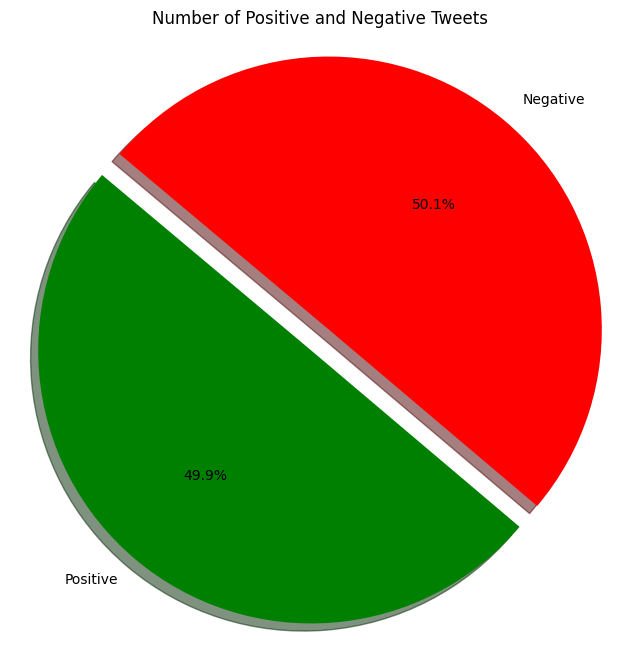

In [ ]:
# Assuming you have two DataFrames: df_test_pos and df_test_neg
# and each row represents a tweet.
pos_count = len(df_test_pos)
neg_count = len(df_test_neg)

# Labels and counts for the pie chart
labels = ['Positive', 'Negative']
sizes = [pos_count, neg_count]

# Optional: define custom colors and an explode effect to highlight a slice
colors = ['green', 'red']
explode = (0.1, 0)  # Explode the first slice (Positive) for emphasis

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.title('Number of Positive and Negative Tweets')
plt.axis('equal')  # Ensures the pie is drawn as a circle.
plt.show()


let's remove stop words and see the the diffreant 


In [159]:
# removeing stop words
df_mearge_pos['tokens'] = df_mearge_pos['tokens'].apply(lambda x: [word for word in x if word not in stopwords_list])
df_mearge_neg['tokens'] = df_mearge_neg['tokens'].apply(lambda x: [word for word in x if word not in stopwords_list])

In [160]:
# see the most word frequancy in postive with number of frequancy
df_mearge_pos['tokens'].explode().value_counts()

tokens
اله         5354
الهم        2328
الهلال      1517
pos         1336
الخير       1220
            ... 
مشية           1
فرس            1
المؤمنات       1
المسلمات       1
فلرب           1
Name: count, Length: 48119, dtype: int64

In [161]:
# see the most word frequancy in negtive with number of frequancy
df_mearge_neg['tokens'].explode().value_counts()    

tokens
اله           3101
الي           1586
واله          1373
انا           1315
ان            1090
              ... 
إمكانك           1
شريكالحياه       1
السوشال          1
اتعمق            1
وانخذل           1
Name: count, Length: 46555, dtype: int64

findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font f

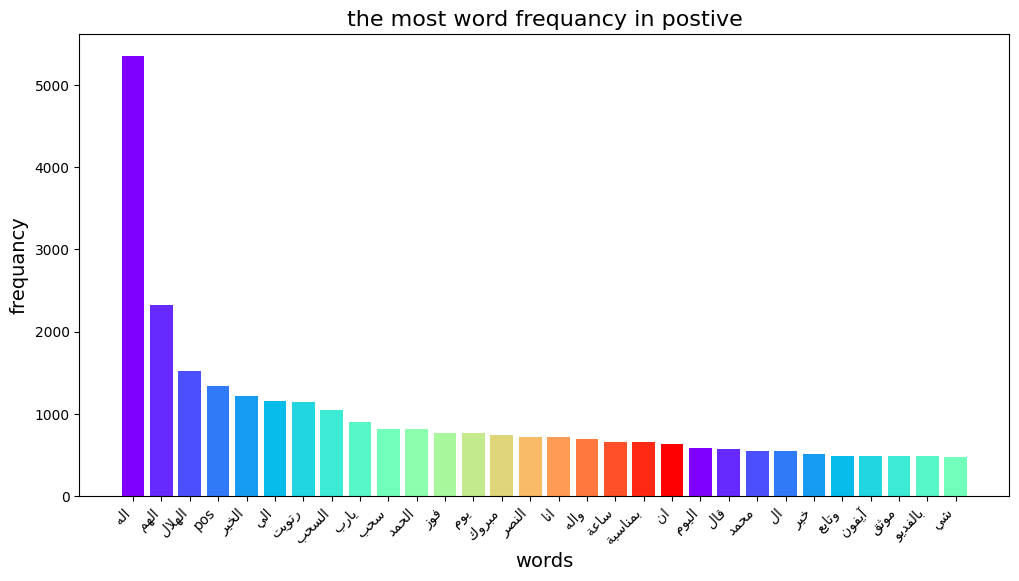

In [ ]:
# Assume your DataFrame is named df_mearge_pos and contains a column "tokens"
# that holds token lists for each row.
# Change the font to one that is installed and supports Arabic
# 1. Get the top 30 most frequent tokens
token_counts = df_mearge_pos['tokens'].explode().value_counts().head(30)

# 2. Reshape each token for proper Arabic rendering:
reshaped_tokens = [get_display(arabic_reshaper.reshape(token)) for token in token_counts.index]
# 3. Set up Matplotlib to use an Arabic-supporting font.
# Change 'Amiri' to another Arabic font if necessary (e.g., 'Noto Naskh Arabic', 'Cairo', etc.)
plt.rcParams['font.family'] = 'Amiri'
plt.rcParams['axes.unicode_minus'] = False

colors = cm.rainbow(np.linspace(0, 1, 20))
# 4. Plot the bar chart with custom color and Arabic labels:
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(reshaped_tokens, token_counts.values, color=colors)

# Reshape and reverse the Arabic labels for title and axes:
title_ar = get_display(arabic_reshaper.reshape("the most word frequancy in postive"))
xlabel_ar = get_display(arabic_reshaper.reshape("words"))
ylabel_ar = get_display(arabic_reshaper.reshape("frequancy"))

ax.set_title(title_ar, fontsize=16)
ax.set_xlabel(xlabel_ar, fontsize=14)
ax.set_ylabel(ylabel_ar, fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.show()


findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font f

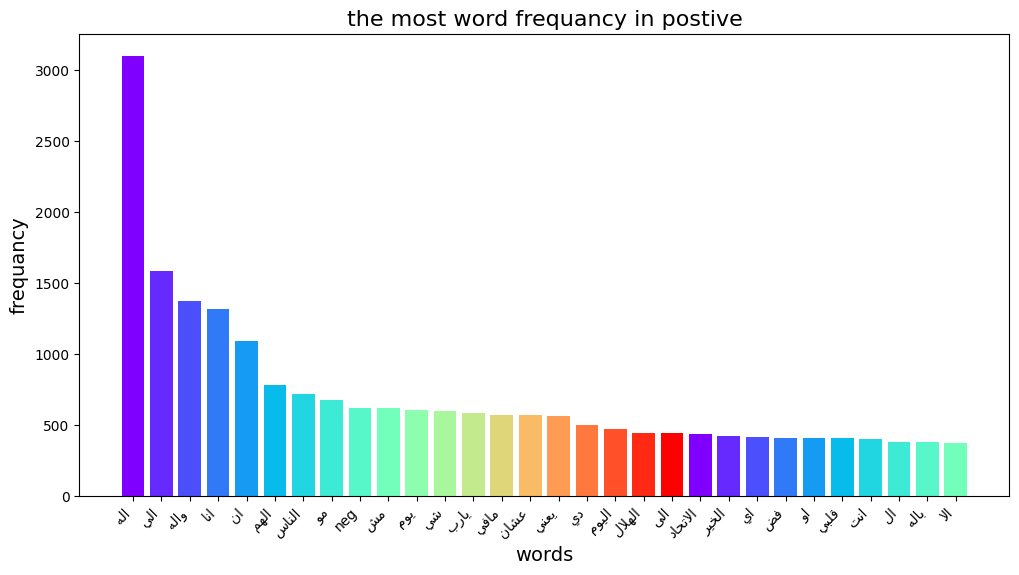

In [ ]:
# Assume your DataFrame is named df_mearge_pos and contains a column "tokens"
# that holds token lists for each row.
# Change the font to one that is installed and supports Arabic
# 1. Get the top 30 most frequent tokens
token_counts = df_mearge_neg['tokens'].explode().value_counts().head(30)

# 2. Reshape each token for proper Arabic rendering:
reshaped_tokens = [get_display(arabic_reshaper.reshape(token)) for token in token_counts.index]
# 3. Set up Matplotlib to use an Arabic-supporting font.
# Change 'Amiri' to another Arabic font if necessary (e.g., 'Noto Naskh Arabic', 'Cairo', etc.)
plt.rcParams['font.family'] = 'Amiri'
plt.rcParams['axes.unicode_minus'] = False

colors = cm.rainbow(np.linspace(0, 1, 20))
# 4. Plot the bar chart with custom color and Arabic labels:
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(reshaped_tokens, token_counts.values, color=colors)

# Reshape and reverse the Arabic labels for title and axes:
title_ar = get_display(arabic_reshaper.reshape("the most word frequancy in postive"))
xlabel_ar = get_display(arabic_reshaper.reshape("words"))
ylabel_ar = get_display(arabic_reshaper.reshape("frequancy"))

ax.set_title(title_ar, fontsize=16)
ax.set_xlabel(xlabel_ar, fontsize=14)
ax.set_ylabel(ylabel_ar, fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.show()


findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.


findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.
findfont: Font family 'Amiri' not found.


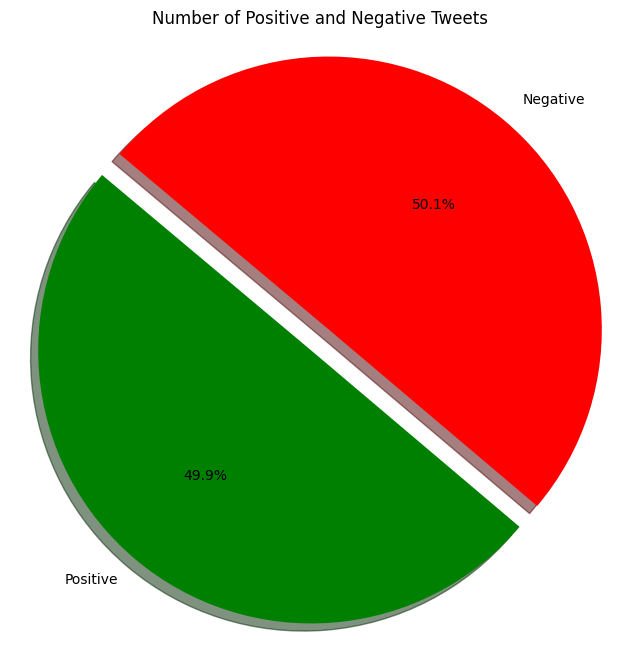

In [ ]:
# Assuming you have two DataFrames: df_test_pos and df_test_neg
# and each row represents a tweet.
pos_count = len(df_test_pos)
neg_count = len(df_test_neg)

# Labels and counts for the pie chart
labels = ['Positive', 'Negative']
sizes = [pos_count, neg_count]

# Optional: define custom colors and an explode effect to highlight a slice
colors = ['green', 'red']
explode = (0.1, 0)  # Explode the first slice (Positive) for emphasis

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.title('Number of Positive and Negative Tweets')
plt.axis('equal')  # Ensures the pie is drawn as a circle.
plt.show()


# model


In [ ]:
#   1 for positive tweets and 0 for negative tweets.

df_train_pos['label'] = 1
df_train_neg['label'] = 0
df_test_pos['label'] = 1
df_test_neg['label'] = 0

# Combine training and test sets
train_df = pd.concat([df_train_pos, df_train_neg]).reset_index(drop=True)
test_df = pd.concat([df_test_pos, df_test_neg]).reset_index(drop=True)

# For clarity, display the first few rows
print("Training Data Sample:")
print(train_df.head())
print("\nTest Data Sample:")
print(test_df.head())

# Create a classification pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', max_df=0.9, min_df=2)),
    ('clf', LinearSVC())
])

# Fit the model on the training data
pipeline.fit(train_df["Arabic tweet"], train_df["label"])

# Predict on the test set
y_pred = pipeline.predict(test_df["Arabic tweet"])

# Evaluate the model
accuracy = accuracy_score(test_df["label"], y_pred)
precision = precision_score(test_df["label"], y_pred)
recall = recall_score(test_df["label"], y_pred)
f1 = f1_score(test_df["label"], y_pred)

print("Model Evaluation on Test Set:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:")
print(classification_report(test_df["label"], y_pred))

Training Data Sample:
  Sentiment Label                                       Arabic tweet  \
0             pos  نحن الذين يتحول كل ما نود أن نقوله إلى دعاء له...   
1             pos  وفي النهاية لن يبقى معك آحدإلا من رأى الجمال ف...   
2             pos                                    من الخير نفسه 💛   
3             pos  زلزلالملعبنصرنابيلعب كن عالي الهمه ولا ترضى بغ...   
4             pos  الشيء الوحيد الذي وصلوا فيه لعالمية هو المسيار...   

                                              tokens  label  
0  [يتحول, نود, نقوله, دعاء, تبحثوا, فينا, قوة, م...      1  
1  [وفي, النهاية, يبقى, معك, آحدإلا, الجمال, روحك...      1  
2                                      [الخير, نفسه]      1  
3  [زلزلالملعبنصرنابيلعب, عالي, الهمه, ترضى, بغير...      1  
4  [الشيء, الوحيد, وصلوا, لعالمية, المسيار, ترى, ...      1  

Test Data Sample:
  Sentiment Label                                       Arabic tweet  \
0             pos  الهلالالاهلي فوز هلالي مهم الحمد له 💙 زوران كا...   
1         

In [179]:
def predict_sentiment(text, model_pipeline):
    """
    Predict the sentiment of an Arabic tweet using a trained model pipeline.
    
    Parameters:
        text (str or list): A single Arabic tweet or a list of tweets.
        model_pipeline: A trained scikit-learn pipeline with a TF-IDF vectorizer and classifier.
        
    Returns:
        A list of sentiment predictions with labels "Positive" or "Negative".
    """
    # Map the numeric predictions to their corresponding sentiment strings
    label_map = {1: "Positive", 0: "Negative"}
    
    # If a single string is passed, convert it to a list
    if isinstance(text, str):
        text = [text]
    
    # Make predictions using the trained model pipeline
    numeric_predictions = model_pipeline.predict(text)
    
    # Convert numeric predictions to sentiment labels
    sentiment_predictions = [label_map[label] for label in numeric_predictions]
    
    return sentiment_predictions

# Example usage:
sample_tweet = "متوقعه يصير شي 💔"
predicted_label = predict_sentiment(sample_tweet, pipeline)
print("Predicted sentiment:", predicted_label)


Predicted sentiment: ['Negative']


In [180]:
import joblib

# Assuming your trained model pipeline is stored in a variable called "pipeline"
joblib.dump(pipeline, 'sentiment_pipeline.pkl')
print("Model saved!")


Model saved!
